### Data Preprocessing

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('Eluvio_DS_Challenge.csv')

In [3]:
df = df.drop(columns=['down_votes', 'category'])

Add a column to indicate nth content for each author.

In [4]:
# sort by time
df.sort_values(by=['time_created'], inplace=True)
# nth content by each author
df['nth_content'] = df.groupby(['author']).cumcount()+1

In [5]:
df.head()

,time_created,date_created,up_votes,title,over_18,author,nth_content
0,1201232046,2008-01-25,3,Scores killed in Pakistan clashes,False,polar,1
1,1201232075,2008-01-25,2,Japan resumes refuelling mission,False,polar,2
2,1201232523,2008-01-25,3,US presses Egypt on Gaza border,False,polar,3
3,1201233290,2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420,1
4,1201274720,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,1


In [6]:
# only first n contents for each author
df = df[df.nth_content == 1]

In [7]:
df.shape

(85838, 7)

In [9]:
df[df.nth_content == 1].shape

(85838, 7)

In [8]:
## text preprocessing functions
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re

stopwords = stopwords.words()
english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%','{','}']
for p in english_punctuations:
    stopwords.append(p)
    
# regular expression pattern for url link
url_patter = r'(http[s]?://)?(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def filter_word(text):
    ## tokenize
#     words_split = nltk.word_tokenize(re.sub(url_patter, '', text)) # remove link
    words_split = nltk.word_tokenize(text.lower().split('|')[0]) # lowercase, remove things after | that tend to be link
    
    lemmatizer = WordNetLemmatizer()
    ## tag (lemmatizer in nltk need part of speech as input to lemmatize word, especially for verb and adjective)
    i = 0
    words_filtered = ''
    for tag in nltk.pos_tag(words_split):
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        ## lemmatize
        word = lemmatizer.lemmatize(tag[0], pos=wordnet_pos)
        ## remove punctuation
        if word.lower() not in english_punctuations:
             words_filtered += (word + ' ')
#         ## remove stopwords
#         if word.lower() not in stopwords:
#              words_filtered += (word + ' ')
    
    return words_filtered

In [43]:
%%time
df.reset_index(inplace=True, drop=True)
df['title_filtered'] = df.title.apply(lambda x: filter_word(x))

Wall time: 2min 26s


In [11]:
df.reset_index(inplace=True, drop=True)
df.sample(10)['title'].apply(lambda x: filter_word(x))

26489                 sri lankan air force purchase jf-17 
45874    enormous craft detect moon result three terrie...
38486    young female british backpacker drink counterf...
37916     norway pm become taxi driver day canvas opinion 
35349          5 convict qatari mall fire kill 13 toddler 
11874    iceland supreme court rule constitutional asse...
72306                        russia issue currency crimea 
22101          arrest offensive tweet follow olympic loss 
24984              japan approve new stimulus ail economy 
71387            syrian suspected link say enter thailand 
Name: title, dtype: object

### Feature extraction

In [12]:
def text_length(text):
    return len(text.split(' '))

df['title_length'] = df.title.apply(lambda x: text_length(x))

In [13]:
df.head()

,time_created,date_created,up_votes,title,over_18,author,nth_content,title_filtered,title_length
0,1201232046,2008-01-25,3,Scores killed in Pakistan clashes,False,polar,1,score kill pakistan clash,5
1,1201233290,2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420,1,jump-start economy give health,8
2,1201274720,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,1,council europe bash terror blacklist,7
3,1201287889,2008-01-25,15,Hay presto! Farmer unveils the illegal mock-...,False,Armagedonovich,1,presto farmer unveils illegal mock-tudor castl...,18
4,1201289438,2008-01-25,5,"Strikes, Protests and Gridlock at the Poland-U...",False,Clythos,1,strike protest gridlock poland-ukraine border,8


In [14]:
df['time_created2'] = pd.to_datetime(df.time_created, unit='s')
# the day of week
df['weekday'] = df['time_created2'].dt.dayofweek
# the hour of a day
df['hour'] = df['time_created2'].apply(lambda x: x.hour)
# morning, afternoon, evening, night, early morning
def time_period(hour):
    if hour>=5 and hour<12:
        return 'morning'
    if hour>=12 and hour<=17:
        return 'afternoon'
    if hour>17 and hour<20:
        return 'evening'
    if hour>=20 or hour<=1:
        return 'night'
    if hour>1 and hour<5:
        return 'early_morning'
df['time_peroid'] = df.hour.apply(lambda x: time_period(x))
# weekday dummy
weekday = pd.get_dummies(df.weekday)
df2 = pd.concat([df, weekday], axis=1)
# time period dummy
time_period = pd.get_dummies(df.time_peroid)
df2 = pd.concat([df2, time_period], axis=1)


In [15]:
df2.sample(20)

,time_created,date_created,up_votes,title,over_18,author,nth_content,title_filtered,title_length,time_created2,...,2,3,4,5,6,afternoon,early_morning,evening,morning,night
36237,1373122657,2013-07-06,26,Train carrying 70 tanks of flammable liquid de...,False,jpeuvion,1,train carry 70 tank flammable liquid derails b...,13,2013-07-06 14:57:37,...,0,0,0,1,0,1,0,0,0,0
22259,1344405704,2012-08-08,0,The 3 Most Excellent Qualities that make Micha...,False,sexychickjune1231,1,3 excellent quality make michael phelps unbeat...,10,2012-08-08 06:01:44,...,1,0,0,0,0,0,0,0,1,0
32604,1366986109,2013-04-26,10,Former Pakistani President Pervez Musharraf ha...,False,fuufnfr,1,former pakistani president pervez musharraf “ ...,22,2013-04-26 14:21:49,...,0,0,1,0,0,1,0,0,0,0
56139,1413584696,2014-10-17,3,Russia And China Want To Build The Longest Hig...,False,Dyspareuniac,1,russia china build long high-speed railway wor...,16,2014-10-17 22:24:56,...,0,0,1,0,0,0,0,0,0,1
74126,1454953936,2016-02-08,15,President Obama requests $1.8 billion in emerg...,False,Stubborntilldate,1,president obama request 1.8 billion emergency ...,12,2016-02-08 17:52:16,...,0,0,0,0,0,1,0,0,0,0
50554,1399717947,2014-05-10,143,China blames U.S. for stoking tensions in Sout...,False,umwelter,1,china blame u.s. stoke tension south china,10,2014-05-10 10:32:27,...,0,0,0,1,0,0,0,0,1,0
75655,1458016155,2016-03-15,20,North Korean leader orders nuclear warhead tes...,False,BrokenNin,1,north korean leader order nuclear warhead test...,14,2016-03-15 04:29:15,...,0,0,0,0,0,0,1,0,0,0
69359,1446393385,2015-11-01,3,Australian Islamic Leader Says Muslim Schoolch...,False,wgtt911,1,australian islamic leader say muslim schoolchi...,12,2015-11-01 15:56:25,...,0,0,0,0,1,1,0,0,0,0
39915,1379245701,2013-09-15,5,India test fires n-capable Agni-V missile,False,antorobin,1,india test fire n-capable agni-v missile,6,2013-09-15 11:48:21,...,0,0,0,0,1,0,0,0,1,0
7430,1254128949,2009-09-28,1,A person apparently managed to extract some ``...,False,ingreenheaven,1,person apparently manage extract `` sensitive ...,35,2009-09-28 09:09:09,...,0,0,0,0,0,0,0,0,1,0


##### Sentiment analysis

In [16]:
from textblob import TextBlob

def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def polarity(text):
    return TextBlob(text).sentiment.polarity

df2['Sentiment_Subjectivity'] = df2['title'].apply(subjectivity)
df2['Sentiment_Polarity'] = df2['title'].apply(polarity)
df2.head()

,time_created,date_created,up_votes,title,over_18,author,nth_content,title_filtered,title_length,time_created2,...,4,5,6,afternoon,early_morning,evening,morning,night,Sentiment_Subjectivity,Sentiment_Polarity
0,1201232046,2008-01-25,3,Scores killed in Pakistan clashes,False,polar,1,score kill pakistan clash,5,2008-01-25 03:34:06,...,1,0,0,0,1,0,0,0,0.0,-0.20
1,1201233290,2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420,1,jump-start economy give health,8,2008-01-25 03:54:50,...,1,0,0,0,1,0,0,0,0.0,0.00
2,1201274720,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,1,council europe bash terror blacklist,7,2008-01-25 15:25:20,...,1,0,0,1,0,0,0,0,0.0,0.00
3,1201287889,2008-01-25,15,Hay presto! Farmer unveils the illegal mock-...,False,Armagedonovich,1,presto farmer unveils illegal mock-tudor castl...,18,2008-01-25 19:04:49,...,1,0,0,0,0,1,0,0,0.6,-0.45
4,1201289438,2008-01-25,5,"Strikes, Protests and Gridlock at the Poland-U...",False,Clythos,1,strike protest gridlock poland-ukraine border,8,2008-01-25 19:30:38,...,1,0,0,0,0,1,0,0,0.0,0.00


In [17]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(ngram_range=(1,2), norm=None, min_df=20, stop_words="english", max_df=0.8)
tf_matrix = tf_vectorizer.fit_transform(df2['title_filtered'])

Wall time: 2.1 s


In [18]:
tf_matrix.shape

(85838, 5304)

Using raw metrix from tf-idf always led to meomory error. So I decided to use **SVD (singular value decomposition)** to reduce dimentions.With only 25 features after SVD, the computation time dropped dramatically and the performance was still fairly satisfying.

In [19]:
%%time
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=25, algorithm='arpack')
svd_matrix = svd.fit_transform(tf_matrix)
svd_feature = pd.DataFrame(svd_matrix)
svd_feature.columns = ['svd_word_' + str(i) for i in range(25)]

Wall time: 428 ms


In [20]:
df2.reset_index(inplace=True, drop=True)
df3 = pd.concat([df2, svd_feature], axis=1)
df3.head()

,time_created,date_created,up_votes,title,over_18,author,nth_content,title_filtered,title_length,time_created2,...,svd_word_15,svd_word_16,svd_word_17,svd_word_18,svd_word_19,svd_word_20,svd_word_21,svd_word_22,svd_word_23,svd_word_24
0,1201232046,2008-01-25,3,Scores killed in Pakistan clashes,False,polar,1,score kill pakistan clash,5,2008-01-25 03:34:06,...,-1.212058,-0.314427,0.026195,0.144628,0.620931,-0.961978,-0.152650,0.043705,-0.201367,0.370855
1,1201233290,2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420,1,jump-start economy give health,8,2008-01-25 03:54:50,...,0.206808,-0.006253,0.137379,0.001299,0.003819,-0.122178,-0.063235,-0.014595,0.141418,-0.005541
2,1201274720,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,1,council europe bash terror blacklist,7,2008-01-25 15:25:20,...,0.054443,-0.248105,0.282851,-0.090122,0.153322,0.031190,-0.196655,0.036538,0.210157,0.059161
3,1201287889,2008-01-25,15,Hay presto! Farmer unveils the illegal mock-...,False,Armagedonovich,1,presto farmer unveils illegal mock-tudor castl...,18,2008-01-25 19:04:49,...,0.070824,-0.026357,-0.072573,0.010440,-0.099353,-0.217995,-0.012128,0.065066,0.047915,-0.149351
4,1201289438,2008-01-25,5,"Strikes, Protests and Gridlock at the Poland-U...",False,Clythos,1,strike protest gridlock poland-ukraine border,8,2008-01-25 19:30:38,...,-0.419275,-0.605568,0.008199,-0.990052,0.502644,0.679367,-1.219191,-0.475144,-1.654060,3.335281


In [21]:
df3.to_csv('processed data.csv', index=False)

In [13]:
df3 = pd.read_csv('processed data.csv')

In [14]:
def up_votes_category(up_votes):
    if up_votes>20:
        return 'high'
    return 'low'

df3['up_votes_category'] = df3.up_votes.apply(up_votes_category)

In [15]:
low = df3[df3.up_votes_category=='low']
high = df3[df3.up_votes_category=='high']

In [16]:
min_number = df3.up_votes_category.value_counts().min()

In [17]:
df3.up_votes_category.value_counts()

low     67846
high    17992
Name: up_votes_category, dtype: int64

In [18]:
data = pd.concat([low.sample(min_number), high.sample(min_number)], axis=0)

In [19]:
data.shape

(35984, 53)

### Random forest classification

In [50]:
y = data.up_votes_category
X = data[['nth_content','title_length',0,1,2,3,4,5,6,'afternoon','early_morning','evening','morning','night','Sentiment_Subjectivity','Sentiment_Polarity','svd_word_0','svd_word_1','svd_word_2','svd_word_3','svd_word_4','svd_word_5','svd_word_6','svd_word_7','svd_word_8','svd_word_9','svd_word_10','svd_word_11','svd_word_12','svd_word_13','svd_word_14','svd_word_15','svd_word_16','svd_word_17','svd_word_18','svd_word_19','svd_word_20','svd_word_21','svd_word_22','svd_word_23','svd_word_24']]

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)

In [52]:
%%time
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rfc.fit(X_train, y_train) 

y_test_pred = rfc.predict(X_test)
y_train_pred = rfc.predict(X_train)

Wall time: 1.62 s


In [53]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

        high       0.59      0.53      0.56     14370
         low       0.57      0.63      0.60     14417

    accuracy                           0.58     28787
   macro avg       0.58      0.58      0.58     28787
weighted avg       0.58      0.58      0.58     28787

              precision    recall  f1-score   support

        high       0.59      0.51      0.55      3622
         low       0.56      0.64      0.60      3575

    accuracy                           0.57      7197
   macro avg       0.58      0.57      0.57      7197
weighted avg       0.58      0.57      0.57      7197



### Word embedding, RNN

In [9]:
tokenized_titles = []
for title in df.title:
    tokenized_titles.append(filter_word(title))

In [10]:
max_length = 0
for title in tokenized_titles:
#     print(title)
    l = len(title.split())
    if max_length < l:
        max_length = l

print(max_length)

73


In [11]:
length = {}
for title in tokenized_titles:
    l = len(title.split())
    length[l] = length.get(l, 0)+1

In [12]:
from operator import itemgetter
sorted_length = sorted(length.items(),
                                  reverse=False,
                                  key=itemgetter(0))

In [13]:
len(sorted_length)

63

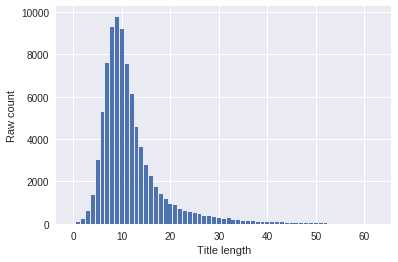

In [14]:
num_top_length_to_plot = len(sorted_length)
length = [l for l, count in sorted_length]
counts = [count for l, count in sorted_length]
plt.bar(range(len(sorted_length)), counts)
# plt.xticks(range(len(sorted_length)), length, rotation=45)
plt.xlabel('Title length')
plt.ylabel('Raw count')
plt.show()

In [15]:
word_counts = {}
for tokenized_title in tokenized_titles:
    for word in tokenized_title.split():
        word_counts[word.strip()] = word_counts.get(word.strip(), 0) + 1
        
from operator import itemgetter
sorted_word_counts = sorted(word_counts.items(),
                                  reverse=True,
                                  key=itemgetter(1))

In [16]:
vocab_size = 2000
word_to_idx = {}
idx_to_word = {}
for i, (word, _) in enumerate(sorted_word_counts[:vocab_size]):
    word_to_idx[word.strip()] = i+1
    idx_to_word[i+1] = word.strip()

In [17]:
len(idx_to_word)

2000

In [18]:
from keras.preprocessing import sequence

X = []
for tokenized_title in tokenized_titles:
    title_idx = []
    for word in tokenized_title.split():
        if word_to_idx.get(word.strip(), 0) > 0:
            title_idx.append(word_to_idx[word.strip()])
        else:
            title_idx.append(0)
    X.append(title_idx)

X = sequence.pad_sequences(X, maxlen=20)

Using TensorFlow backend.


In [19]:
X.shape

(85838, 20)

In [20]:
def up_votes_category(up_votes):
    if up_votes>20:
        return 1
    return 0

y = [] 
for up_votes in df.up_votes:
    y.append(up_votes_category(up_votes))

In [21]:
len(y)

85838

In [44]:
y[y==1].sum()

17992

In [47]:
import numpy as np
np.random.seed(seed=2019)

y = np.array(y)
mask_1 = y==1
X_1 = X[mask_1]
y_1 = y[mask_1]

mask_2 = y==0
X_2 = X[mask_2]
y_2 = y[mask_2]
random_idx = np.random.permutation(X_2.shape[0])
X_2 = X_2[random_idx[:X_1.shape[0]]]
y_2 = y_2[random_idx[:X_1.shape[0]]]
# min_number = df3.up_votes_category.value_counts().min()
# data = pd.concat([low.sample(min_number), high.sample(min_number)], axis=0)

In [50]:
X_balance = np.concatenate((X_1, X_2), axis=0)
y_balance = np.concatenate((y_1, y_2), axis=0)

In [56]:
import numpy as np
np.random.seed(seed=2019)

random_idx = np.random.permutation(X_balance.shape[0])
train_num = int(X_balance.shape[0]*0.8)
X_train = X_balance[random_idx[:train_num]]
X_test = X_balance[random_idx[train_num:]]
y_train = y_balance[random_idx[:train_num]]
y_test = y_balance[random_idx[train_num:]]

In [61]:
X_balance.shape

(35984, 20)

In [57]:
X_train.shape

(28787, 20)

In [24]:
word_to_embedding = {}

# we will use the 100-dimensional embedding vectors
with open("pretrained_word2vec_vectors.txt") as f:
    # each row represents a word vector
    for idx, line in enumerate(f):
        if idx>0:
            values = line.split()
            # the first part is word
            word = values[0]
            # the rest of the values form the embedding vector
            embedding = np.asarray(values[1:], dtype='float32')
            embedding = embedding/np.linalg.norm(embedding) # L2 norm
            word_to_embedding[word] = embedding

print('Found %s word vectors.' % len(word_to_embedding))

Found 15173 word vectors.


In [25]:
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for idx in range(vocab_size):
    word = idx_to_word[idx+1]
    if word in word_to_embedding:
        embedding_matrix[idx] = word_to_embedding[word]

In [72]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, embedding_dim, input_length=20))
rnn_model.add(LSTM(64))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dense(1, activation='sigmoid'))

# load the GloVe embeddings in the model
rnn_model.layers[0].set_weights([embedding_matrix])
rnn_model.layers[0].trainable = False

In [73]:
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 100)           200000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 246,465
Trainable params: 46,465
Non-trainable params: 200,000
_________________________________________________________________


In [75]:
# compile and train the model
rnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])
history = rnn_model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=10,
                        batch_size=32)

Train on 23029 samples, validate on 5758 samples
Epoch 1/10
23029/23029 [==============================] - 30s 1ms/step - loss: 0.6770 - acc: 0.5727 - val_loss: 0.6806 - val_acc: 0.5651
Epoch 2/10
23029/23029 [==============================] - 28s 1ms/step - loss: 0.6751 - acc: 0.5773 - val_loss: 0.6794 - val_acc: 0.5656
Epoch 3/10
23029/23029 [==============================] - 29s 1ms/step - loss: 0.6736 - acc: 0.5794 - val_loss: 0.6784 - val_acc: 0.5689
Epoch 4/10
23029/23029 [==============================] - 28s 1ms/step - loss: 0.6710 - acc: 0.5827 - val_loss: 0.6844 - val_acc: 0.5592
Epoch 5/10
23029/23029 [==============================] - 28s 1ms/step - loss: 0.6696 - acc: 0.5859 - val_loss: 0.6783 - val_acc: 0.5677
Epoch 6/10
23029/23029 [==============================] - 29s 1ms/step - loss: 0.6677 - acc: 0.5891 - val_loss: 0.6784 - val_acc: 0.5650
Epoch 7/10
23029/23029 [==============================] - 28s 1ms/step - loss: 0.6652 - acc: 0.5926 - val_loss: 0.6820 - val_acc:

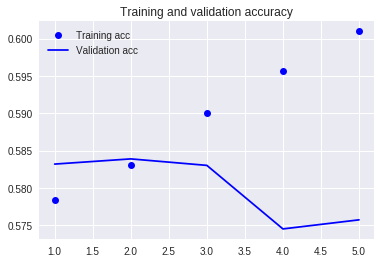

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# plot the accuracy rates for each epoch on training and validation data
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [67]:
test_loss, test_acc = rnn_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

7197/7197 [==============================] - 3s 462us/step
Test accuracy: 0.5945532860831451


In [68]:
# check data balance
y_train.sum()/y_train.shape[0]

0.5004689616840935

In [69]:
y_train_predict = rnn_model.predict_classes(X_train)
y_test_predict = rnn_model.predict_classes(X_test)

In [70]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_predict))
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.58      0.69      0.63     14380
           1       0.62      0.51      0.56     14407

    accuracy                           0.60     28787
   macro avg       0.60      0.60      0.60     28787
weighted avg       0.60      0.60      0.60     28787

              precision    recall  f1-score   support

           0       0.58      0.69      0.63      3612
           1       0.62      0.50      0.55      3585

    accuracy                           0.59      7197
   macro avg       0.60      0.59      0.59      7197
weighted avg       0.60      0.59      0.59      7197

